In [1]:
from __future__ import print_function
from model import RouteNet
import tensorflow as tf
import numpy as np
from read_dataset import generator
import os
from torchviz import make_dot, make_dot_from_trace
tr_path = r'G:\My Drive\CLASSES\WI21\Project\RouteNet-challenge2\RouteNet-challenge\data\sample_data'

In [25]:
for batch, delay in generator(tr_path):
    x = batch
    y = delay
    break

[[None 10000 None None None 25000 None None None None None None None None
  None None None None None]
 [10000 None 10000 None 10000 40000 None None None None None None None
  None None None None 10000 10000]
 [None 10000 None 25000 None None None None None None None None None None
  None None None None None]
 [None None 25000 None None 40000 None None None None None None None None
  None None None None None]
 [None 10000 None None None 25000 None None None None None None None None
  None None None None None]
 [25000 40000 None 40000 25000 None 25000 25000 40000 None None 40000
  None None 40000 40000 None 25000 None]
 [None None None None None 25000 None None None None None None None None
  None None None None None]
 [None None None None None 25000 None None 10000 None None None None
  10000 None None None None None]
 [None None None None None 40000 None 10000 None 25000 None 10000 None
  None None None None None None]
 [None None None None None None None None 25000 None 10000 None Non

AttributeError: 'dict' object has no attribute 'shape'

In [27]:
import torch
import torch.nn as nn
x['links'] = torch.unsqueeze(torch.tensor(x['links']),1)                         
x['paths'] = torch.unsqueeze(torch.tensor(x['paths']),1)                 
x['sequences'] = torch.unsqueeze(torch.tensor(x['sequences']),1)
x['link_capacity'] = torch.unsqueeze(torch.tensor(x['link_capacity']).float(),axis=1)
x['bandwith'] = torch.unsqueeze(torch.tensor(x['bandwith']).float(), axis=1)

In [70]:
import torch.nn.functional as F

In [156]:

class RouteNet(nn.Module):

    def __init__(self):
        super(RouteNet,self).__init__()

        ### Architecture ###
        # for gru need to pay attention to if input is of size:
        # (batch, seq_len, feature size) or seq_len, batch, feature size
        # if sequence length is variable
        # may need to pad the sequence
        
        self.link_state_dim = 32
        self.path_state_dim = 32
        self.readout_dim = 8
        self.output_units = 1
        self.T = 8

        inSize = 10 # place holder
        hSize  = 32
        readSize = 10
        nLayer = 1

        self.l_U = nn.GRU(input_size = self.link_state_dim,
                          hidden_size = hSize,
                          num_layers = nLayer,
                          batch_first=True)
        
        self.p_U = nn.GRU(input_size = self.path_state_dim,
                          hidden_size = hSize,
                          num_layers = nLayer,
                          batch_first=True)
        
        self.readOut = nn.ModuleDict({  'r1': nn.Linear(hSize,self.readout_dim),
                                        'r2': nn.Linear(self.readout_dim,self.readout_dim),
                                        'r3': nn.Linear(self.readout_dim,self.output_units)
                                        })
        

    def forward(self,x):
        
        links = x['links']
        paths = x['paths']
        seqs  = x['sequences']
        bandwidth = x['bandwith']
        link_cap  = x['link_capacity']

        # state matrix shape for the link
        link_h_state_shape = (x['n_links'], self.link_state_dim-1)

        # create hidden state matrix for links and initialize with first column as link capacity
        l_h_empty = torch.zeros(link_h_state_shape)
        link_h_state = torch.cat((link_cap,l_h_empty),1)

        # create hidden state matrix shape for the path  
        path_h_state_shape = (x['n_paths'],self.path_state_dim-1)
        path_h_state = torch.cat((bandwidth,torch.zeros(path_h_state_shape)), axis=1)
        
        # prepare input for path update RNN
        max_seq_len = torch.max(seqs)
        path_rnn_input_shape = (x['n_paths'],max_seq_len+1,self.link_state_dim)
        
        #stack the paths and sequences
        ids = torch.stack((paths,seqs),axis=1)
        ids = torch.squeeze(ids,2)           
        p_ind = ids[:,0]
        s_ind = ids[:,1]

        # flatten the double loop into a bulk matrix using the gather functionality
        # this is an aggregation of the state vector of each link on each path flattened into a (sum_paths(sum_links_on_paths) x h_state) size matrix 
        indices = torch.zeros(len(links),32)
        for i in range(len(links)):
            link_id = links[i]
            indices[i,:] = link_id
            
        path_rnn_input = torch.zeros((path_rnn_input_shape))

        for t in range(1):
            
            # take link state matrix and turn into a list that states the link hidden state
            # as they appear on the flattened path list i.e the 'links' list
            h_t_links_on_paths = torch.gather(link_h_state,0,indices.long())
            path_rnn_input = path_rnn_input.index_put(indices = [p_ind,s_ind],values = h_t_links_on_paths)
            
            hidden_states, path_h_state = self.p_U(path_rnn_input,torch.unsqueeze(path_h_state,0))
            path_h_state = path_h_state.squeeze(0)
            
            # For every link, gather the input from the hidden states of the paths
            # outputs is size (n_path, max_seq, link_state_dim)  182 x 3 x 32
            # ids are size (sum_path(sum_link_in_path) x 2)      390 x 2
            # pytorch doesn't have a gather_nd instead it will grab by output
            
            # equivalent to gather_nd
            # https://discuss.pytorch.org/t/how-to-do-the-tf-gather-nd-in-pytorch/6445]
            link_messages = hidden_states[p_ind,s_ind,:]
           
            # aggregate the messages
            # aggregated link message is size (n_links x link state dim)
            # aggregated along rows based on link index in the links vector
            aggregated_link_message = torch.zeros((x['n_links'],self.link_state_dim),requires_grad=True)
            aggregated_link_message = aggregated_link_message.scatter_add(0,links,link_messages)

            # update the state of the links
            _, link_h_state = self.l_U(torch.unsqueeze(aggregated_link_message,1), torch.unsqueeze(link_h_state,0))
            link_h_state = link_h_state.squeeze(0)

            ############### simulated second pass - i.e t = 2 ###################
            h_t_links_on_paths2 = torch.gather(link_h_state,0,indices.long())
            path_rnn_input2 = torch.zeros((path_rnn_input_shape))
            path_rnn_input2.requires_grad = True
            path_rnn_input2 = path_rnn_input2.index_put(indices = [p_ind,s_ind],values = h_t_links_on_paths)
            hidden_states2, path_h_state2 = self.p_U(path_rnn_input,torch.unsqueeze(path_h_state,0))
            path_h_state2 = path_h_state2.squeeze(0)
            link_messages2 = hidden_states2[p_ind,s_ind,:]
            
            # aggregate the messages
            # aggregated link message is size (n_links x link state dim)
            # aggregated along rows based on link index in the links vector
            aggregated_link_message2 = torch.zeros((x['n_links'],self.link_state_dim),requires_grad=True)
            aggregated_link_message2 = aggregated_link_message2.scatter_add(0,links,link_messages)

            # update the state of the links
            _, link_h_state2 = self.l_U(torch.unsqueeze(aggregated_link_message2,1), torch.unsqueeze(link_h_state,0))
            link_h_state2 = link_h_state2.squeeze(0)
            

        # readout from the paths
        y = self.readout(path_h_state2)
        return y


    def readout(self,path_state):
        x = F.relu(self.readOut['r1'](path_state))
        x = F.relu(self.readOut['r2'](x))
        x = self.readOut['r3'](x)
        return x

In [160]:
# Code snippet from runner

def train(model,label):
    optimizer = torch.optim.Adam(model.parameters(), .001) # optimizer method for gradient descent
    criterion = torch.nn.MSELoss() 
    model.train() #put model in training mode
    for epoch in range(10):
        tr_loss = []
        optimizer.zero_grad()  
        outputs = model(x)
        print(outputs[0].dtype,torch.tensor(label)[0].dtype)
        loss = criterion(outputs, torch.unsqueeze(torch.tensor(label),1)) 
        loss.backward()                        
        optimizer.step()                  
        tr_loss.append(loss.item())
        print(torch.mean(torch.tensor(tr_loss)))

In [158]:
model = RouteNet()
model = model.float()

In [159]:
yy = model(x)

In [111]:
yy

tensor([[-0.1632],
        [-0.1654],
        [-0.1654],
        [-0.1654],
        [-0.1632],
        [-0.1654],
        [-0.1654],
        [-0.1654],
        [-0.1726],
        [-0.1726],
        [-0.1654],
        [-0.1726],
        [-0.1726],
        [-0.1654],
        [-0.1654],
        [-0.1726],
        [-0.1654],
        [-0.1654],
        [-0.1632],
        [-0.1632],
        [-0.1654],
        [-0.1632],
        [-0.1632],
        [-0.1654],
        [-0.1654],
        [-0.1654],
        [-0.1726],
        [-0.1726],
        [-0.1654],
        [-0.1726],
        [-0.1726],
        [-0.1654],
        [-0.1654],
        [-0.1654],
        [-0.1632],
        [-0.1632],
        [-0.1654],
        [-0.1632],
        [-0.1632],
        [-0.1654],
        [-0.1654],
        [-0.1726],
        [-0.1726],
        [-0.1726],
        [-0.1791],
        [-0.1791],
        [-0.1726],
        [-0.1791],
        [-0.1791],
        [-0.1726],
        [-0.1726],
        [-0.1726],
        [-0.

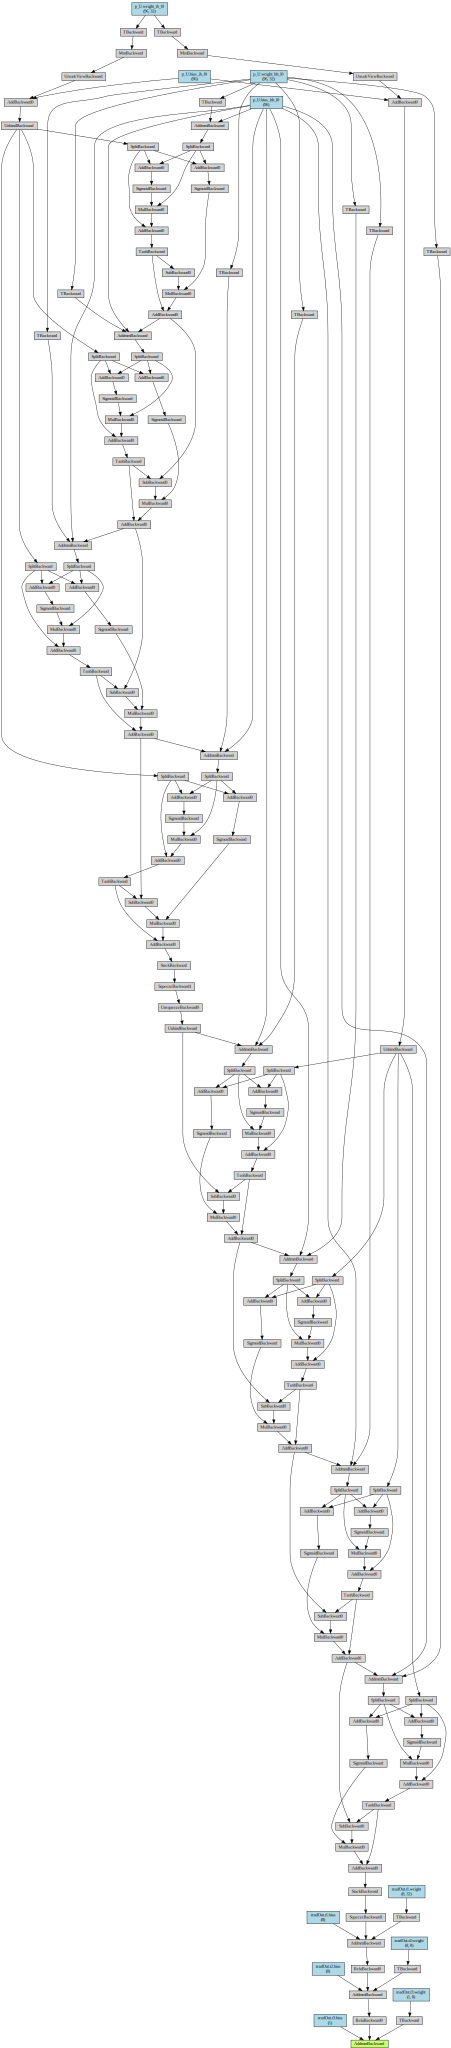

In [123]:
make_dot(yy,params=dict(model.named_parameters()))

In [161]:
train(model,y)

torch.float32 torch.float32
tensor(1.6690)
torch.float32 torch.float32
tensor(1.5350)
torch.float32 torch.float32
tensor(1.4064)
torch.float32 torch.float32
tensor(1.2851)
torch.float32 torch.float32
tensor(1.1744)
torch.float32 torch.float32
tensor(1.0695)
torch.float32 torch.float32
tensor(0.9619)
torch.float32 torch.float32
tensor(0.8443)
torch.float32 torch.float32
tensor(0.7529)
torch.float32 torch.float32
tensor(0.6700)


In [13]:
tr_loss

NameError: name 'tr_loss' is not defined